## Dependencies

In [1]:
!pip install xgboost --upgrade

     |████████████████████████████████| 173.5 MB 61 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
!pip install shap

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509231 sha256=2d8a249e8ac26599b4d0194cea855a88eb923f944e004d9b21535285b8695093
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [3]:
import  pandas as pd,\
  google.colab as gcl,\
  xgboost as xgb,\
  sklearn.model_selection as slms,\
  shap as shp,\
  sklearn.metrics as slm,\
  numpy as np,\
  matplotlib.pyplot as pypl


In [4]:
pypl.style.use('bmh')

In [5]:
gcl.drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Data

In [6]:
df_train_input = pd.read_csv(
  './drive/MyDrive/2021/NUS_MSBA/DBA5106/5106: FBA Project/Housing Price Dataset/train.csv',
  header='infer',
  index_col=False
)


In [7]:
df_cost_matrix = df_train_input[['SalePrice','OpenPorchSF']]

In [8]:
df_train_input.drop(columns=['OverallCond','OverallQual','SalePrice'], inplace=True )

In [9]:
df_train_input['YrSold'] = df_train_input['YrSold'].astype('object')
df_train_input['MoSold'] = df_train_input['MoSold'].astype('object')
df_train_input['YearBuilt'] = df_train_input['YearBuilt'].astype('object')
df_train_input['YearRemodAdd'] = df_train_input['YearRemodAdd'].astype('object')
df_train_input['GarageYrBlt'] = df_train_input['GarageYrBlt'].astype('object')


In [10]:
df_train_input.dropna(subset=[ 'LotFrontage'] ,inplace=True)

In [11]:
categorical_columns = df_train_input.select_dtypes(include='object').columns.tolist()

df_train_dummies = pd.get_dummies(data=df_train_input,columns=categorical_columns)




In [ ]:
(df_train_dummies['OpenPorchSF'] > 0).value_counts()

True     946
False    746
Name: OpenPorchSF, dtype: int64

In [ ]:
print(946/(746+946))

0.5591016548463357


## Classification

In [ ]:
# Create classifier
df_train_dummies['class_porch'] = df_train_dummies['OpenPorchSF'] > 0

In [ ]:
input_features =  df_train_dummies.columns.tolist()
input_features.remove('Id')
input_features.remove('class_porch')
input_features.remove('OpenPorchSF')

In [ ]:
X_train, X_test, y_train, y_test = slms.train_test_split(
  df_train_dummies[input_features],
  df_train_dummies['class_porch'],
  test_size=0.25 
)

In [ ]:
xgboost_classifier = xgb.XGBClassifier(n_jobs=4,verbosity=3)

In [ ]:
xgboost_classifier.fit(
  X_train, 
  y_train, 
#  early_stopping_rounds=10, 
  eval_metric="auc",
  eval_set=[(X_test, y_test)]
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:43] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.81197
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.82461
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.81353
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.81736
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.81381
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.81173
[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=3)

## Profit curve

In [ ]:
y_proba = xgboost_classifier.predict_proba(X_test)[:,1]

In [12]:
# Cell values corresponds to those in the confusion matrix [[tp, fp], [fn, tn]]

mean_porch_average = df_cost_matrix[df_cost_matrix['OpenPorchSF']>0 ]['SalePrice'].mean() - df_cost_matrix[df_cost_matrix['OpenPorchSF'] == 0 ]['SalePrice'].mean()  

mean_porch_square_feet = df_cost_matrix[df_cost_matrix['OpenPorchSF']>0 ]['OpenPorchSF'].mean()

mean_porch_deviation = df_cost_matrix[df_cost_matrix['OpenPorchSF']>0 ]['SalePrice'].std() - df_cost_matrix[df_cost_matrix['OpenPorchSF'] == 0 ]['SalePrice'].std()

costbenefit_mat = np.array(
  [
    [mean_porch_average, -110 * mean_porch_square_feet], 
    [0,0]
  ]
)

In [ ]:
thresholds = sorted(y_proba, reverse=True)

profits = []

# For each threshold, calculate profit
for T in thresholds:
    y_pred_profit = (y_proba > T).astype(int) # predict label based on the cutoff thresholds
    [[tn, fp], [fn, tp]] = slm.confusion_matrix(y_test.astype('int'), y_pred_profit) # get the confusion matrix for each threshold
    confusion_mat = np.array([[tp, fp], [fn, tn]])
    # Calculate total profit (in the test data) for this threshold
    profit = sum(sum(confusion_mat * costbenefit_mat))
    profits.append(profit)

In [ ]:
# Profit curve plot
pypl.plot(np.linspace(0, 1, len(y_test)), profits)
pypl.xlabel('Test instances proportion (descending by score)')
pypl.ylabel('USD Profit')
pypl.title('Profit Curve - Open Porch')

pypl.gcf().set_size_inches(14, 10)

pypl.savefig('./expected_value_openporch.png')
#pypl.show()
pypl.close('all')

In [ ]:
print("The optimal total profit of ", max(profits),"is obtained with threshold of ", thresholds[np.argmax(profits)])

The optimal total profit of  13644209.042940827 is obtained with threshold of  0.0020107056


In [13]:
mean_porch_average


65930.09179711202

In [14]:
mean_porch_square_feet

83.94439617723718

## Stochastic Expected value

In [ ]:
thresholds = sorted(y_proba, reverse=True)

profits = []

# For each threshold, calculate profit
for T in thresholds:
    y_pred_profit = (y_proba > T).astype(int) # predict label based on the cutoff thresholds
    [[tn, fp], [fn, tp]] = slm.confusion_matrix(y_test.astype('int'), y_pred_profit) # get the confusion matrix for each threshold
    confusion_mat = np.array([[ tp , fp], [fn, tn]])
    # Calculate total profit (in the test data) for this threshold
    costbenefit_mat[0][0] = np.random.normal(loc= mean_porch_average, scale=mean_porch_deviation * 0.5,size=1 )[0] 
    profit = sum(sum(confusion_mat * costbenefit_mat))
    profits.append(profit)

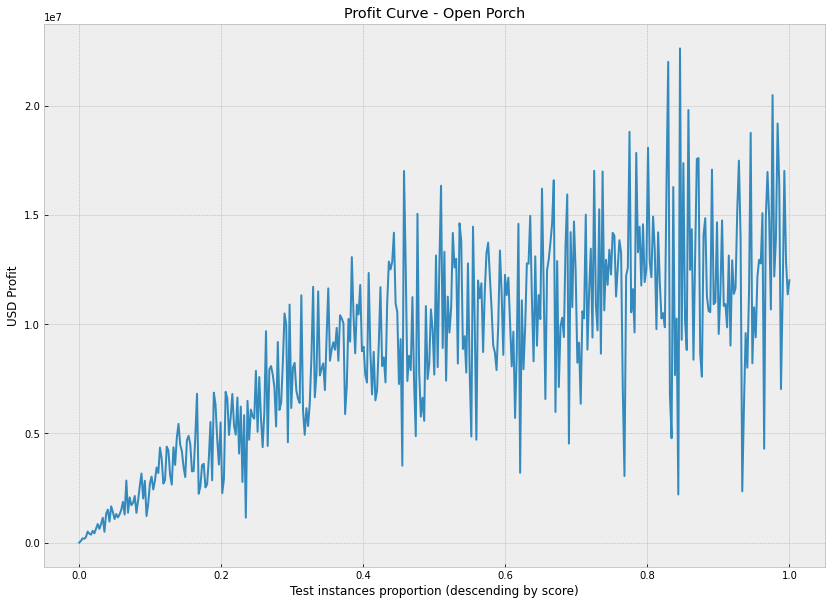

In [ ]:
# Profit curve plot
pypl.plot(np.linspace(0, 1, len(y_test)), profits )
pypl.xlabel('Test instances proportion (descending by score)')
pypl.ylabel('USD Profit')
pypl.title('Profit Curve - Open Porch')

pypl.gcf().set_size_inches(14, 10)

pypl.show()
pypl.close('all')

In [ ]:
print("The optimal total profit of ", max(profits),"is obtained with threshold of ", thresholds[np.argmax(profits)])

The optimal total profit of  22618105.553057738 is obtained with threshold of  0.04807701


## Explainability

In [ ]:
explainer = shp.TreeExplainer(xgboost_classifier)

shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


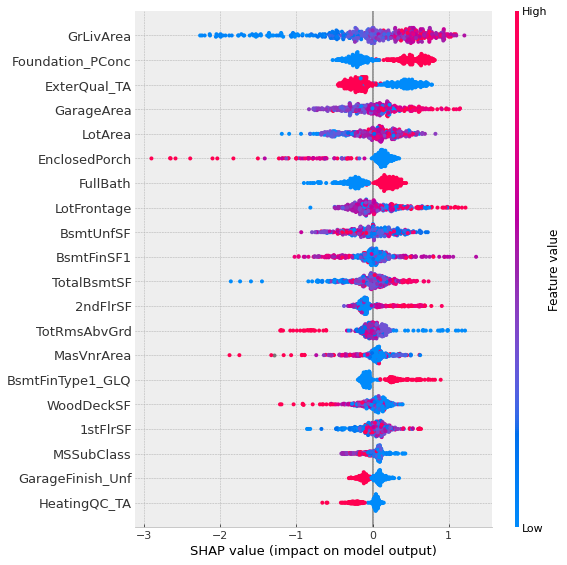

In [ ]:
shp.summary_plot(shap_values,X_test)